In [ ]:
'''
https://docs.openvinotoolkit.org/latest
/_models_intel_face_detection_adas_binary_0001_description_face_detection_adas_binary_0001.html

Name: input, shape: [1x3x384x672] - An input image in the format [BxCxHxW], where:

The net outputs blob with shape: [1, 1, N, 7], where N is the number of detected bounding boxes. For each detection, the description has the format: [image_id, label, conf, x_min, y_min, x_max, y_max]
image_id - ID of the image in the batch
label - predicted class ID
conf - confidence for the predicted class
(x_min, y_min) - coordinates of the top left bounding box corner
(x_max, y_max) - coordinates of the bottom right bounding box corner.


'''

In [5]:
import numpy as np
from openvino.inference_engine import IENetwork,IECore
import cv2
from matplotlib import pyplot as plt

model_name = 'models/face-detection-adas-binary-0001/FP32-INT1/face-detection-adas-binary-0001'

In [53]:
class face_detection:
    
    
    def __init__(self, model_name, device='CPU', extensions=None):
        
        self.model_weights=model_name+'.bin'
        self.model_structure=model_name+'.xml'
        self.device=device

    def load_model(self):
        
        # Loading network to device
        self.core = IECore()
        self.model=self.core.read_network(self.model_structure, self.model_weights)
       
        self.net = self.core.load_network(network=self.model, device_name=self.device, num_requests=1)
        
        print("Successfully loaded the network")
        
    def pre_process_input(self,image):
        self.image=image#cv2.imread(image_path)
        #print("Input shape",image.shape) #height, width, channel 
        resized_img = cv2.resize(self.image, (672,384)) #width,height
        #resized_img.shape
        input_img = np.moveaxis(resized_img, -1, 0)
        input_img=np.expand_dims(input_img, axis=0)
        #print("shape: ",input_img.shape)
        return input_img
        
    def check_model(self):
        layers_supported = self.core.query_network(network=self.model, device_name="CPU")
        layers_in_model = self.model.layers.keys()
        all_layers_supported = True
        for l in layers_in_model:
            if l  not in layers_supported:
                all_layers_supported = False
                print('Layer', l, 'is not supported')
        if all_layers_supported:
            print('All layers supported')

    def get_input_name(self):
        self.input_name = next(iter(self.net.inputs))
        
    def predict(self, image):
        result = self.net.infer({self.input_name:image})
        return result
    
    def preprocess_output(self, res):
        prediction = res.get('detection_out')
        
        count=0
        ih, iw = self.image.shape[:-1]
        tmp_image = self.image
        self.boxes=[]

        for results in prediction[0][0]:
            if (np.int(results[1])==1 and results[2] > 0.9):
                count +=1
                xmin = np.int(iw * results[3])
                ymin = np.int(ih * results[4])
                xmax = np.int(iw * results[5])
                ymax = np.int(ih * results[6])

                self.boxes.append([xmin, ymin, xmax, ymax])
                
        #for box in self.boxes:
        #    cv2.rectangle(tmp_image, (box[0], box[1]), (box[2], box[3]), (232, 35, 244), 2)
        return tmp_image,self.boxes
        
    def plot_image(self,output_image):
        img = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize = (15,9))

        plt.imshow(img,interpolation='nearest', aspect='auto')
        plt.show()
        
    def save_image(self,image_id,image):
        cv2.imwrite("bin/face_detection-{}.jpg".format(image_id+1), image)
        print("saved image as: bin/face_detection-{}.jpg".format(image_id+1))
        
    def cropped_image(self):
        cropped_output = []
        for id,images in enumerate(self.boxes):
            crop_img_org = self.image[images[1]:images[3], images[0]:images[2]]
            #ymin:ymax, xmin:xmax 
            #cv2.imwrite("bin/face-{}.jpg".format(id+1), crop_img_org)
            #print("saved cropped image as: bin/face-{}.jpg".format(id+1))
            cropped_output.append(crop_img_org)
        return cropped_output
    
    def get_face_location(self):   
        face_loc_list=[]
        
        for face_id,box in enumerate(self.boxes):
            face_loc = self.image[box[1]:box[3], box[0]:box[2]]
            #ymin:ymax, xmin:xmax
            face_loc_list.append(face_loc)
        return face_loc_list



In [54]:
fd = face_detection(model_name)
fd.load_model()
fd.check_model()
fd.get_input_name()

Successfully loaded the network
All layers supported


1 bin/img1.png


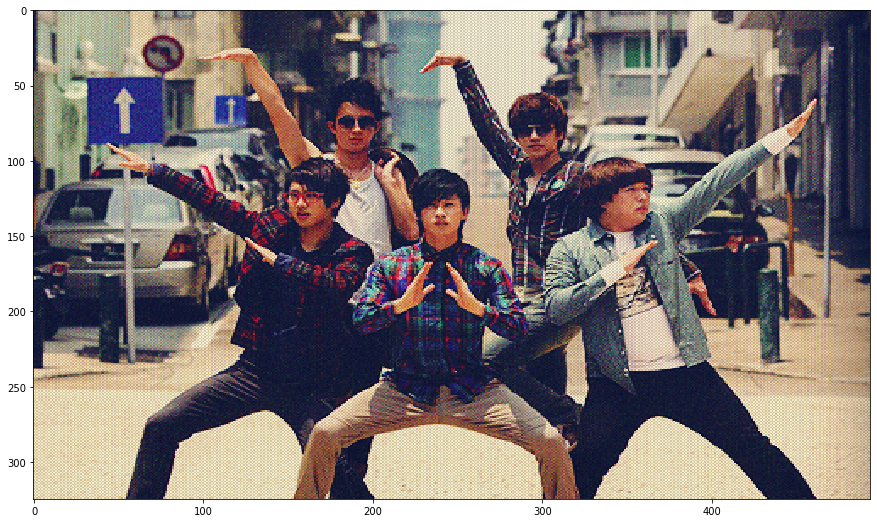

saved image as: bin/face_detection-1.jpg


In [55]:
input_image = ['bin/img1.png']
face_box = []
for image_id,input_img in enumerate(input_image):
    print(image_id+1,input_img)
    input_img = cv2.imread(input_img)
    input_img = fd.pre_process_input(input_img)
    result = fd.predict(input_img)
    output_image,boxes = fd.preprocess_output(result)
    face_box.append(boxes)
    fd.plot_image(output_image)
    fd.save_image(image_id,output_image)
    fd.cropped_image()

In [49]:
input_image[0],len(input_image)

('bin/img1.png', 1)

0 [177, 61, 202, 95] 0
1 [340, 112, 362, 141] 0
2 [285, 69, 307, 98] 0
3 [229, 122, 252, 149] 0
4 [149, 113, 171, 144] 0


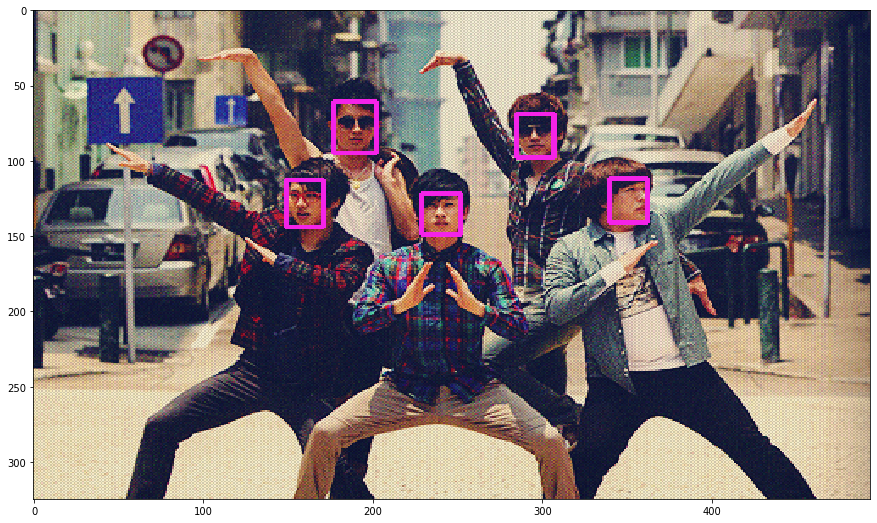

In [58]:
for image_id,faces in enumerate(face_box):
    temp_image = cv2.imread(input_image[image_id])
    for face_id,box in enumerate(faces):
        print(face_id,box,image_id)
        cv2.rectangle(temp_image, (box[0], box[1]), (box[2], box[3]), (232, 35, 244), 2)

fd.plot_image(temp_image)

In [2]:
%%writefile face_detection.py

import numpy as np
from openvino.inference_engine import IENetwork,IECore
import cv2
from matplotlib import pyplot as plt

class face_detection:
    
    
    def __init__(self, model_name, device='CPU', extensions=None):
        
        self.model_weights=model_name+'.bin'
        self.model_structure=model_name+'.xml'
        self.device=device

    def load_model(self):
        
        # Loading network to device
        self.core = IECore()
        self.model=self.core.read_network(self.model_structure, self.model_weights)
       
        self.net = self.core.load_network(network=self.model, device_name=self.device, num_requests=1)
        
        print("Successfully loaded the network")
        
    def pre_process_input(self,image):
        self.image=image#cv2.imread(image_path)
        #print("Input shape",image.shape) #height, width, channel 
        resized_img = cv2.resize(self.image, (672,384)) #width,height
        #resized_img.shape
        input_img = np.moveaxis(resized_img, -1, 0)
        input_img=np.expand_dims(input_img, axis=0)
        #print("shape: ",input_img.shape)
        return input_img
        
    def check_model(self):
        layers_supported = self.core.query_network(network=self.model, device_name="CPU")
        layers_in_model = self.model.layers.keys()
        all_layers_supported = True
        for l in layers_in_model:
            if l  not in layers_supported:
                all_layers_supported = False
                print('Layer', l, 'is not supported')
        if all_layers_supported:
            print('All layers supported')

    def get_input_name(self):
        self.input_name = next(iter(self.net.inputs))
        
    def predict(self, image):
        result = self.net.infer({self.input_name:image})
        return result
    
    def preprocess_output(self, res):
        prediction = res.get('detection_out')
        
        count=0
        ih, iw = self.image.shape[:-1]
        tmp_image = self.image
        self.boxes=[]

        for results in prediction[0][0]:
            if (np.int(results[1])==1 and results[2] > 0.9):
                count +=1
                xmin = np.int(iw * results[3])
                ymin = np.int(ih * results[4])
                xmax = np.int(iw * results[5])
                ymax = np.int(ih * results[6])

                self.boxes.append([xmin, ymin, xmax, ymax])
                
        #for box in self.boxes:
        #    cv2.rectangle(tmp_image, (box[0], box[1]), (box[2], box[3]), (232, 35, 244), 2)
        return tmp_image,self.boxes
        
    def plot_image(self,output_image):
        img = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize = (15,9))

        plt.imshow(img,interpolation='nearest', aspect='auto')
        plt.show()
        
    def save_image(self,image_id,image):
        cv2.imwrite("bin/face_detection-{}.jpg".format(image_id+1), image)
        print("saved image as: bin/face_detection-{}.jpg".format(image_id+1))
        
    def cropped_image(self):
        cropped_output = []
        for id,images in enumerate(self.boxes):
            crop_img_org = self.image[images[1]:images[3], images[0]:images[2]]
            #ymin:ymax, xmin:xmax 
            #cv2.imwrite("bin/face-{}.jpg".format(id+1), crop_img_org)
            #print("saved cropped image as: bin/face-{}.jpg".format(id+1))
            cropped_output.append(crop_img_org)
        return cropped_output
    
    def get_face_location(self):   
        face_loc_list=[]
        
        for face_id,box in enumerate(self.boxes):
            face_loc = self.image[box[1]:box[3], box[0]:box[2]]
            #ymin:ymax, xmin:xmax
            face_loc_list.append(face_loc)
        return face_loc_list



Overwriting face_detection.py


In [4]:
#Preprocess input
image=cv2.imread(imput_image)
print("Input shape",image.shape) #height, width, channel 
resized_img = cv2.resize(image, (672,384)) #width,height
#resized_img.shape
input_img = np.moveaxis(resized_img, -1, 0)
input_img=np.expand_dims(input_img, axis=0)
print("shape: ",input_img.shape)

Input shape (325, 494, 3)
shape:  (1, 3, 384, 672)


In [5]:
#predict
res = fd.net.infer({'data':input_img})
res

{'detection_out': array([[[[0.        , 1.        , 0.9973495 , ..., 0.1906762 ,
           0.41091427, 0.2939199 ],
          [0.        , 1.        , 0.99700975, ..., 0.3460594 ,
           0.7347113 , 0.43553975],
          [0.        , 1.        , 0.9963749 , ..., 0.21535157,
           0.6230975 , 0.30371082],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]]]], dtype=float32)}

In [6]:
prediction = res.get('detection_out')
prediction.shape

(1, 1, 200, 7)

In [7]:
#image_id, label, conf, (x_min, y_min), (x_max, y_max)

prediction[0][0][:5]

array([[0.        , 1.        , 0.9973495 , 0.35890153, 0.1906762 ,
        0.41091427, 0.2939199 ],
       [0.        , 1.        , 0.99700975, 0.68989646, 0.3460594 ,
        0.7347113 , 0.43553975],
       [0.        , 1.        , 0.9963749 , 0.57838994, 0.21535157,
        0.6230975 , 0.30371082],
       [0.        , 1.        , 0.9952616 , 0.4642574 , 0.37708816,
        0.51103735, 0.4608015 ],
       [0.        , 1.        , 0.9919687 , 0.30297822, 0.34875947,
        0.3481617 , 0.44312418]], dtype=float32)

In [8]:
count=0
ih, iw = image.shape[:-1]
tmp_image = image
boxes=[]
probability=[]

for results in prediction[0][0]:
    if (np.int(results[1])==1 and results[2] > 0.9):
        count +=1
        xmin = np.int(iw * results[3])
        ymin = np.int(ih * results[4])
        xmax = np.int(iw * results[5])
        ymax = np.int(ih * results[6])
        
        boxes.append([xmin, ymin, xmax, ymax])
        probability.append([results[2]])
print(count)

5


In [26]:
len(prediction[0][0])
for box,prob in zip(boxes,probability):

    cv2.rectangle(tmp_image, (box[0], box[1]), (box[2], box[3]), (232, 35, 244), 2)
    #mid_x,mid_y =  (box[2]+(box[0]-box[2])//2),(box[3]+(box[1]-box[3])//2)


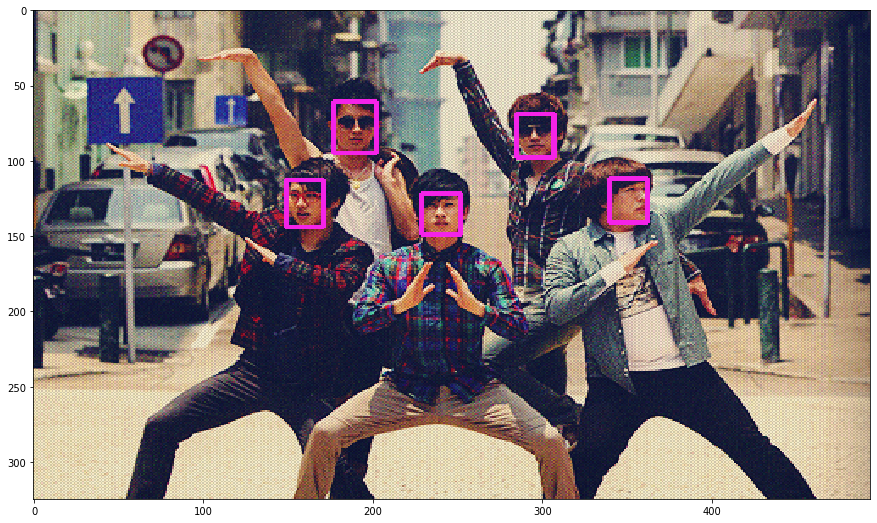

In [24]:
RGB_img = cv2.cvtColor(tmp_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15,9))

plt.imshow(RGB_img,interpolation='nearest', aspect='auto')
plt.show()

In [11]:
boxes

[[177, 61, 202, 95],
 [340, 112, 362, 141],
 [285, 69, 307, 98],
 [229, 122, 252, 149],
 [149, 113, 171, 144]]

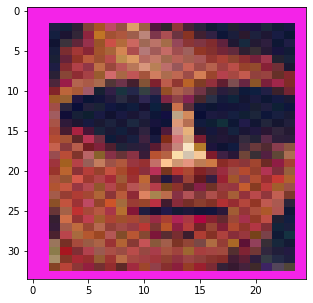

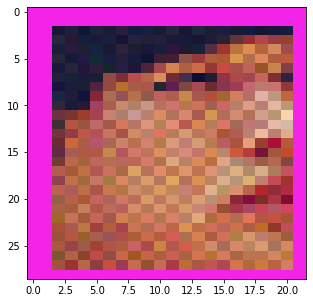

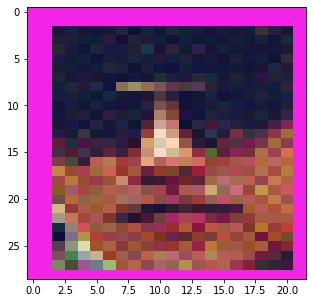

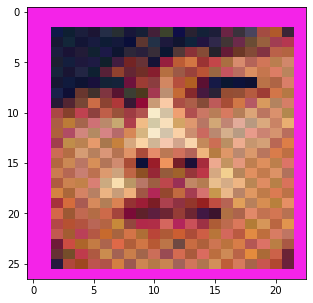

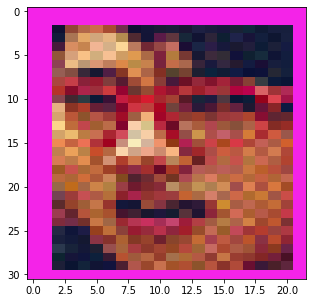

In [20]:
#crop the image and save
for id,images in enumerate(boxes):
    crop_img_org = tmp_image[images[1]:images[3], images[0]:images[2]]
    plt.figure(figsize = (5,5))
    crop_img = cv2.cvtColor(crop_img_org, cv2.COLOR_BGR2RGB)
    plt.imshow(crop_img,interpolation='nearest', aspect='auto')
    cv2.imwrite("bin/face-{}.jpg".format(id+1), crop_img_org)
    plt.show()

In [69]:
#check layers
layers_supported = fd.core.query_network(network=fd.model, device_name="CPU")
layers_in_model = fd.model.layers.keys()
all_layers_supported = True
for l in layers_in_model:
    if l  not in layers_supported:
        all_layers_supported = False
        print('Layer', l, 'is not supported')
if all_layers_supported:
    print('All layers supported')
    
#return all_layers_supported

Layer data is not supported
Layer conv4_3_norm_mbox_priorbox is not supported
Layer conv4_3_0_norm_mbox_priorbox is not supported
Layer fc7_mbox_priorbox is not supported
Layer conv6_2_mbox_priorbox is not supported
Layer conv7_2_mbox_priorbox is not supported
Layer conv8_2_mbox_priorbox is not supported
Layer conv9_2_mbox_priorbox is not supported
Layer mbox_priorbox is not supported
Layer detection_out is not supported


In [63]:

layers_map = fd.core.query_network(network=fd.model, device_name="CPU")

In [ ]:
'''
This is a sample class for a model. You may choose to use it as-is or make any changes to it.
This has been provided just to give you an idea of how to structure your model class.
'''

class Model_X:
    '''
    Class for the Face Detection Model.
    '''
    def __init__(self, model_name, device='CPU', extensions=None):
        '''
        TODO: Use this to set your instance variables.
        '''
        raise NotImplementedError

    def load_model(self):
        '''
        TODO: You will need to complete this method.
        This method is for loading the model to the device specified by the user.
        If your model requires any Plugins, this is where you can load them.
        '''
        raise NotImplementedError

    def predict(self, image):
        '''
        TODO: You will need to complete this method.
        This method is meant for running predictions on the input image.
        '''
        raise NotImplementedError

    def check_model(self):
        raise NotImplementedError

    def preprocess_input(self, image):
    '''
    Before feeding the data into the model for inference,
    you might have to preprocess it. This function is where you can do that.
    '''
        raise NotImplementedError

    def preprocess_output(self, outputs):
    '''
    Before feeding the output of this model to the next model,
    you might have to preprocess the output. This function is where you can do that.
    '''
        raise NotImplementedError
